# Introdução A computação Visual - Trabalho Prático 3
## Luiz Henrique De Melo Santos
## Otávio Augusto Silva

In [1]:
import os
import cv2
import numpy
import seaborn
import tensorflow
from matplotlib import pyplot
from tensorflow.keras import activations, initializers, layers, losses, metrics, models, optimizers, utils

In [2]:
devices = tensorflow.config.list_physical_devices()
try:
    tensorflow.config.experimental.set_memory_growth(devices[1], True)
except:
    print(f"Error when enabling memory growth for device {devices[1]}")

In [3]:
VOCAB = "0123456789ABCDEFGHIJKLMNOPQRSTUVXWYZ"

In [4]:
labels = {}
for filename in os.listdir(os.path.join("CAPTCHA-10k", "labels10k")):
    with open(os.path.join("CAPTCHA-10k", "labels10k", filename), "r") as file:
        line = file.readlines()[0]
        if "?" not in line and len(line) == 7:
            labels[filename.split('.')[0]] = line.replace('\n', '')

In [5]:
vocab_mapping = {i: idx for idx, i in enumerate(VOCAB)}

In [6]:
classes = {}
for key in labels:
    classes[key] = [vocab_mapping[c] for c in labels[key]]

In [7]:
def train_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "treinamento")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "treinamento", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.split(image, 6, axis=1)
            yield (X, y)

In [8]:
def validation_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "validacao")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "validacao", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.array(numpy.split(image, 6, axis=1))
            yield (X, y)

In [9]:
def test_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "teste")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "teste", filename))
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            yield (image, y)

In [10]:
train_dataset = tensorflow.data.Dataset.from_generator(train_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36)))).unbatch()

In [11]:
validation_dataset = tensorflow.data.Dataset.from_generator(validation_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36)))).unbatch()

In [12]:
test_dataset = tensorflow.data.Dataset.from_generator(test_generator, (tensorflow.dtypes.uint8, tensorflow.dtypes.uint8), output_shapes=(tensorflow.TensorShape(((50, 180, 3))), tensorflow.TensorShape((6, 36))))

In [13]:
def create_model(shape: tuple) -> models.Model:
    inputs = tensorflow.keras.Input(shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=initializers.Ones())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=initializers.Ones())(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=initializers.Ones())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=initializers.Ones())(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation=activations.relu, bias_initializer=initializers.Ones())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation=activations.relu, bias_initializer=initializers.Ones())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(VOCAB), activation=activations.softmax, bias_initializer=tensorflow.ones)(x)
    return models.Model(inputs=inputs, outputs=outputs)

In [19]:
model = create_model((50, 30, 3))

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 30, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 30, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 30, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 30, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 15, 64)        3692

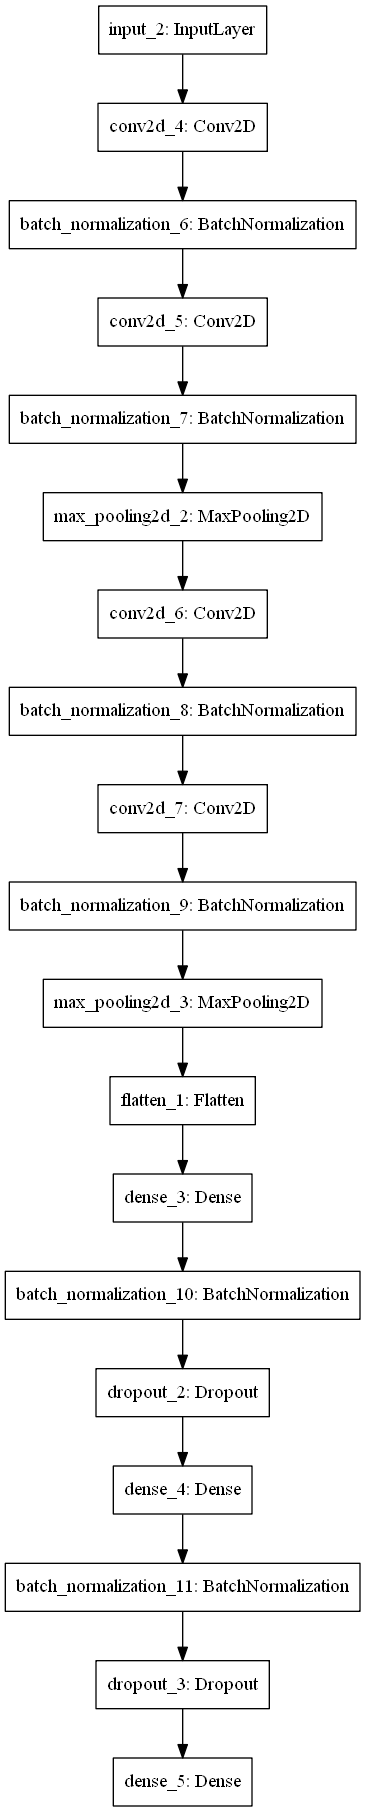

In [21]:
utils.plot_model(model)

In [22]:
model.compile(optimizer=optimizers.Adam(), loss=losses.CategoricalCrossentropy(), metrics=[metrics.CategoricalAccuracy()])

In [23]:
history = model.fit(train_dataset.batch(512), validation_data=validation_dataset.batch(512), epochs=10)

Epoch 1/10
72/72 [==============================] - 17s 237ms/step - loss: 1.6182 - categorical_accuracy: 0.5442 - val_loss: 5.2993 - val_categorical_accuracy: 0.0807
Epoch 2/10
72/72 [==============================] - 13s 183ms/step - loss: 0.5215 - categorical_accuracy: 0.8472 - val_loss: 3.7572 - val_categorical_accuracy: 0.1581
Epoch 3/10
72/72 [==============================] - 13s 182ms/step - loss: 0.3273 - categorical_accuracy: 0.9049 - val_loss: 1.3983 - val_categorical_accuracy: 0.6074
Epoch 4/10
72/72 [==============================] - 13s 182ms/step - loss: 0.2514 - categorical_accuracy: 0.9256 - val_loss: 0.4943 - val_categorical_accuracy: 0.8641
Epoch 5/10
72/72 [==============================] - 13s 182ms/step - loss: 0.2015 - categorical_accuracy: 0.9406 - val_loss: 0.2733 - val_categorical_accuracy: 0.9173
Epoch 6/10
72/72 [==============================] - 13s 183ms/step - loss: 0.1758 - categorical_accuracy: 0.9479 - val_loss: 0.2496 - val_categorical_accuracy: 0.927

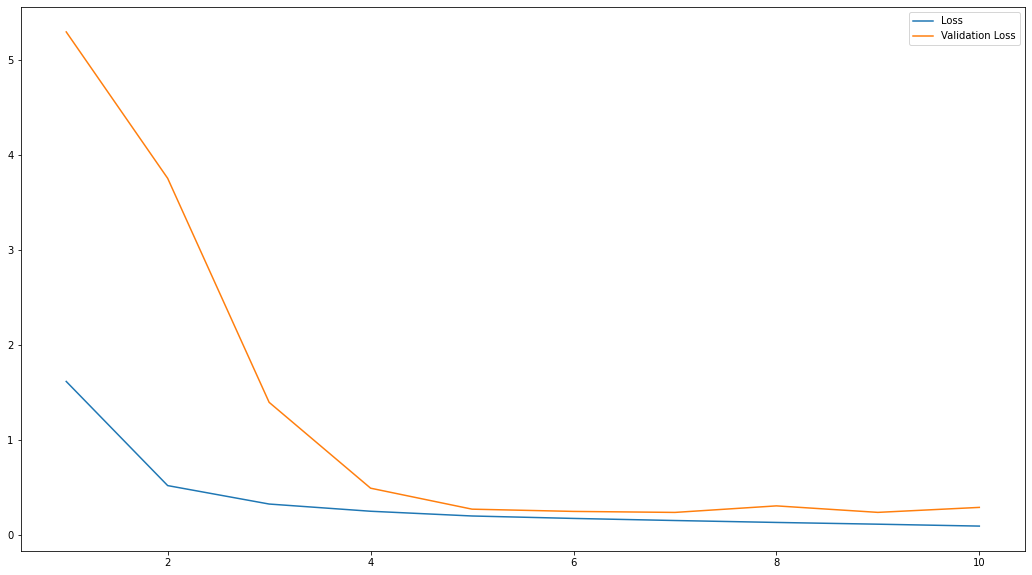

In [24]:
pyplot.figure(figsize=(18, 10))
seaborn.lineplot(x=range(1, 11), y=history.history["loss"], label="Loss")
seaborn.lineplot(x=range(1, 11), y=history.history["val_loss"], label="Validation Loss")
pyplot.show()

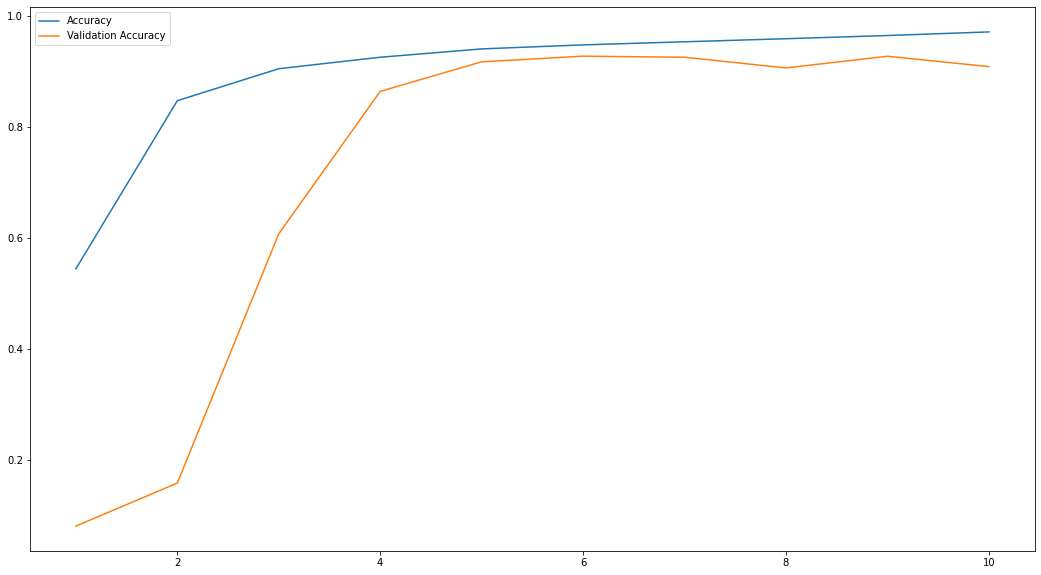

In [25]:
pyplot.figure(figsize=(18, 10))
seaborn.lineplot(x=range(1, 11), y=history.history["categorical_accuracy"], label="Accuracy")
seaborn.lineplot(x=range(1, 11), y=history.history["val_categorical_accuracy"], label="Validation Accuracy")
pyplot.show()

In [38]:
def predict(dataset: tensorflow.data.Dataset):
    cc = losses.CategoricalCrossentropy()
    for item, label in dataset:
        X = tensorflow.convert_to_tensor(tensorflow.split(item, 6, axis=1)) / 255
        #print(X.shape)
        p = model.predict(X)
        #print(p.shape)
        loss = cc(label, p)
        s_true, s_pred = "", ""
        for i in range(label.shape[0]):
            idx = tensorflow.argmax(label[i])
            s_true += VOCAB[idx.numpy()]
            idx = tensorflow.argmax(p[i])
            s_pred += VOCAB[idx.numpy()]
        print(f"Label: {s_true}, Predicted: {s_pred}, Loss: {loss.numpy()}")

In [39]:
predict(test_dataset)

redicted: 4107MB, Loss: 0.12219572067260742
Label: J9DOJH, Predicted: J9DCJH, Loss: 0.17311377823352814
Label: 1ZNVAP, Predicted: 1ZNWAP, Loss: 0.362286239862442
Label: 8W06IM, Predicted: 8W06IM, Loss: 0.06157092750072479
Label: 4CRKRV, Predicted: 4ORKRW, Loss: 0.34722259640693665
Label: 33AHNT, Predicted: 33AHNT, Loss: 0.014753363095223904
Label: G1WXMR, Predicted: G1WXNR, Loss: 0.747063159942627
Label: BIVF5X, Predicted: BIVF5X, Loss: 0.04398098960518837
Label: 8K72A1, Predicted: 8K72A1, Loss: 0.011863884516060352
Label: PGEAND, Predicted: RGEAND, Loss: 0.16185466945171356
Label: DQ74CN, Predicted: DQ74ON, Loss: 0.32891032099723816
Label: 4CQGVE, Predicted: 4CQGWE, Loss: 0.992711067199707
Label: 50L97V, Predicted: 50L97V, Loss: 0.0793544128537178
Label: FFUPH1, Predicted: FFUPH1, Loss: 0.00891230907291174
Label: 26AND8, Predicted: 26AND7, Loss: 1.617543339729309
Label: MDFXVX, Predicted: MDFXWX, Loss: 1.0177019834518433
Label: CA2JFZ, Predicted: CA2JFZ, Loss: 0.04579811170697212
Labe

In [ ]:
for item, label in test_dataset:
    